<a href="https://colab.research.google.com/github/GitAmitesh/SkinDiseaseClassificationCNN/blob/main/model_1_sequential_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!fusermount -u drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/drive


In [3]:
# Path to your .pkl file
file_path = "/content/drive/MyDrive/HAM10000/final_processed_ham_metadata.pkl"

# Load the DataFrame
df = pd.read_pickle(file_path)

# Check the result
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,lesion_type,lesion_type_idx,image_array
0,HAM_0006018,ISIC_0033486,bkl,histo,75.0,male,trunk,/content/drive/MyDrive/HAM10000/HAM10000_image...,Benign keratosis-like lesions,2,"[[[0.62352943, 0.58431375, 0.61960787], [0.619..."
1,HAM_0000206,ISIC_0033925,mel,histo,65.0,female,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Melanoma,5,"[[[0.7529412, 0.57254905, 0.654902], [0.745098..."
2,HAM_0000673,ISIC_0029659,akiec,histo,70.0,female,face,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.75686276, 0.4862745, 0.4862745], [0.73333..."
3,HAM_0000000,aug_normal_skin_0298,ns,none,45.0,unknown,unknown,/content/drive/MyDrive/HAM10000/normal_skin_im...,Normal skin,7,"[[[0.30980393, 0.23529412, 0.1764706], [0.3058..."
4,HAM_0005505,ISIC_0031743,akiec,histo,50.0,male,upper extremity,/content/drive/MyDrive/HAM10000/HAM10000_image...,Actinic keratoses,0,"[[[0.015686275, 0.011764706, 0.003921569], [0...."


In [4]:
# Constants
SIZE = (150, 200, 3)
num_classes = 8
image_shape = (SIZE[0], SIZE[1], SIZE[2])
image_array_path = "/content/drive/MyDrive/HAM10000/final_processed_image_arrays.npy"  # This should be pre-saved memmap file path

# Load memory-mapped image array (not in RAM)
num_images = len(df)
image_arrays_loaded = np.load(image_array_path, mmap_mode='r')

# Labels
Y = df['lesion_type_idx']
Y_cat = to_categorical(Y, num_classes=num_classes)

# Train-test split (indices only)
train_idx, test_idx = train_test_split(np.arange(num_images), test_size=0.25, random_state=42)

In [5]:
# -----------------------------
# Custom Data Generator
# -----------------------------
class MemmapImageGenerator(Sequence):
    def __init__(self, memmap, labels, indices, batch_size=32):
        self.memmap = memmap
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = self.memmap[batch_ids]
        batch_y = self.labels[batch_ids]
        return batch_x, batch_y

# Create training and validation generators
batch_size = 64
train_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, train_idx, batch_size=batch_size)
test_gen = MemmapImageGenerator(image_arrays_loaded, Y_cat, test_idx, batch_size=batch_size)

In [7]:

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=SIZE))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(8, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 64
epochs = 30

early_stop = EarlyStopping(
    monitor='val_loss',        # What to monitor (e.g., val_loss or val_accuracy)
    patience=5,                # How many epochs to wait before stopping (if no improvement)
    restore_best_weights=True # Optional: roll back to best model after stopping
)

history = model.fit(
    train_gen,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = test_gen,
    callbacks = [early_stop],
    verbose=2)

score = model.evaluate(test_gen)
print('Test accuracy:', score[1])



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 198, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 198, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 99, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 99, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 97, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 97, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 34, 46, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25024)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       800,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,178,856 (4.50 MB)

 Trainable params: 1,177,960 (4.49 MB)

 Non-trainable params: 896 (3.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
141/141 - 133s - 945ms/step - acc: 0.4260 - loss: 6.3334 - val_acc: 0.1172 - val_loss: 6.0611
Epoch 2/30
141/141 - 55s - 391ms/step - acc: 0.4978 - loss: 2.7094 - val_acc: 0.1295 - val_loss: 3.3734
Epoch 3/30
141/141 - 55s - 388ms/step - acc: 0.5204 - loss: 2.0249 - val_acc: 0.1788 - val_loss: 2.8297
Epoch 4/30
141/141 - 56s - 394ms/step - acc: 0.5733 - loss: 1.5096 - val_acc: 0.2374 - val_loss: 2.5741
Epoch 5/30
141/141 - 56s - 399ms/step - acc: 0.5757 - loss: 1.4192 - val_acc: 0.4319 - val_loss: 1.7328
Epoch 6/30
141/141 - 82s - 583ms/step - acc: 0.6113 - loss: 1.1692 - val_acc: 0.5408 - val_loss: 1.2188
Epoch 7/30
141/141 - 56s - 399ms/step - acc: 0.6303 - loss: 1.0987 - val_acc: 0.4339 - val_loss: 1.6172
Epoch 8/30
141/141 - 62s - 440ms/step - acc: 0.6436 - loss: 0.9867 - val_acc: 0.5581 - val_loss: 1.2018
Epoch 9/30
141/141 - 57s - 402ms/step - acc: 0.6600 - loss: 0.9549 - val_acc: 0.4752 - val_loss: 1.5075
Epoch 10/30
141/141 - 57s - 403ms/step - acc: 0.6660 - loss: 0.

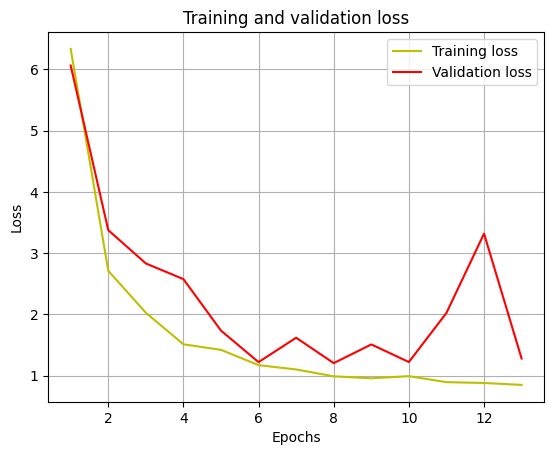

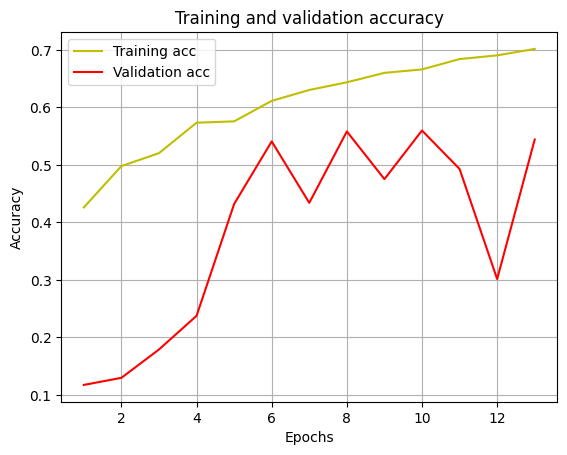

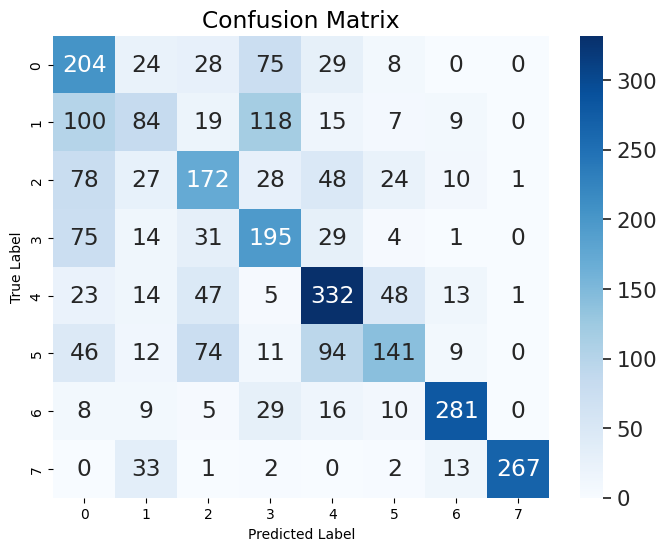

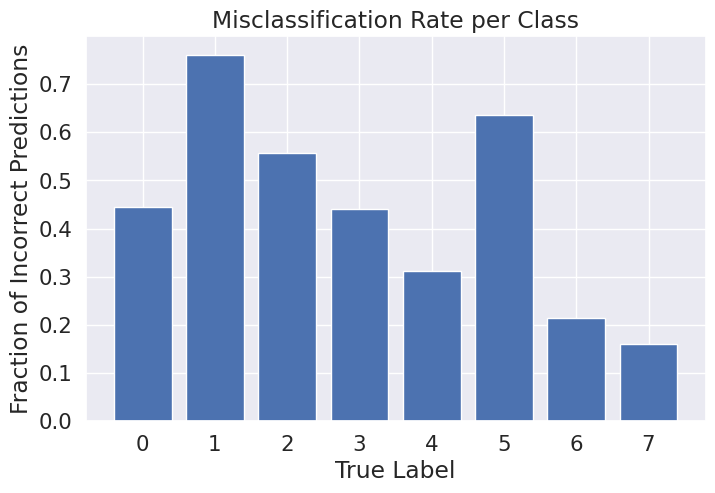

In [8]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Step 1: Collect all predictions and true labels from the test generator
y_true = []
y_pred = []

for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 4: Plot fraction of incorrect predictions per class
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(cm)), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Misclassification Rate per Class')
plt.grid(True)
plt.show()


In [24]:
print(history)